# Car Manufacturer Parts Prediction

A Car Manufacturers needs to sell products; e.g. radio, GPS navigation, speekers, etc. for multiple years after they stop producing. The supplier for these manufacturers needs to keep enough parts avaiable for around 15-20 years, but production for these products end after a few years of production. If the supplier orders too many parts, this could lead to millions of dollars being lost in excess product. Or if the supplier orders too few, this could lead to lower profits and customer statisfaction.

The goal is to create a forecasting tool that will be able to predict the amount of parts needed to keep for these 15-20 years.

In [329]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Explaining the categories

The data set given was provided by a supplier for a car Manufacturer. The data set uses 'ML_category' to outlines specific categories that each part is classifed in. Under 'Type Prod Sold MP_SVC' data is classified as either MP or SVC. MP stands for Mass Production and SVC and for service. MP parts are sold when they are installed into the car and SVC are products sold to consumers when a new part is needed. Sales are counted cumulatively for each year and go up to 14 years. The first year is categorized as 'yr1sales' and year 14 denoted as 'yr14sales'. The last category that I used in my calculation was the 'Reman/non-reman' category. If the part was placed under 'reman' then the part could remanufactured and repaired.'non-reman' means that the product can not be repaired and must be replaced with a SVC part 

In [330]:
df = pd.read_excel("Car Part Data.xlsx")

row, column = df.shape
df.head(6)

,ML_category,Part Number,Type Prod Sold MP_SVC,Last Year SVC Part Sold,intro_year,intro_mp_year,Number of Years SVC Part sold,yr1sales,yr2sales,yr3sales,...,yr8sales,yr9sales,yr10sales,yr11sales,yr12sales,yr13sales,yr14sales,net_price,Market,Reman/non-reman
0,GPS ANT,ACC005,MP,2008,2004,2004,6,10779,24553,31480,...,36079,36079,36079,36079,36079,36079,36079,9,US,non-reman
1,GPS ANT,ACC005,SVC,2009,2004,2004,6,50,140,206,...,277,277,277,277,277,277,277,12,US,non-reman
2,GPS ANT,ACC008,MP,2008,2004,2004,10,9808,22480,30285,...,35375,35375,35375,35375,35375,35375,35375,9,US,non-reman
3,GPS ANT,ACC008,SVC,2013,2004,2005,10,0,19,19,...,35,35,41,41,41,41,41,10,US,non-reman
4,TMC receiver,ACC017,MP,2007,2005,2005,7,453,582,680,...,680,680,680,680,680,680,680,126,US,non-reman
5,TMC receiver,ACC017,SVC,2011,2005,2005,7,4,63,63,...,102,102,102,102,102,102,102,125,US,non-reman


At first I thought of seperating all of the data based on their 'ML_category' but I realised that this made the data too sparse. There would few categories with less than 10 data points and I would also have to further seperate these groups based on their mass production and service quantites.

In [331]:
y = np.array(df)

ACC = y[:30,:] #GPS ANT & TMC receiver & accessory
AMP = y[31:160,:] #AMP/Sound Control
AVN = y[161:162,:] #AVN/AN
CDA = y[163:240,:] #DVD Audio
DIS = y[241:298,:] #display
NAV = y[299:302,:] #Nav Map Disc
PAN = y[303:310,:] #Panel
RAD = y[311:328,:] #Radio Cassette & Radio Cassette CD
SPE = y[329:418,:] #tweeter & subwoofer & speaker

The second approach was to first seperate the data into two groups, MP and SVC. This method made sure that the indecies in the SVC and MassProduction for each part number would match with each other.

In [332]:
b = []
for i in range(0,int(row/2)):
    b.append(i*2 +1)

mask = np.ones(len(y), dtype=bool)
mask[b,] = False
SVC, MassProduction = y[b], y[mask]

## Linear Regression

One of the approaches brought up by in a prior work was to calculate the SVC parts needed based on the number of mass production parts being sold. They would first seperate the parts into reman and non reman groups. Then they would seperate those groups based on the number of mass production products sold. The values I chose for each group was close to the original values used but the first group was changed to fit even bigger data sets. They would then take the average ratio of MP to SVC and use that to predict the service part number on a new proudct. But with this method of just taking the average ratio, there is potentially alot of varience within the data set which would cause a the predicted value to be off. I wanted to check to see if this would be a resonable approach by comparing r-squared values of linear models for each data set.

In [333]:
MPtotalSales = np.ravel(MassProduction[:,20:21])
MPreman = np.ravel(MassProduction[:,23:24])

MPgroup1reman = [] #100,000-2,000,000
MPgroup2reman = [] #20,000-99,999
MPgroup3reman = [] #5,000-19,999
MPgroup4reman = [] #1,000-4,999
MPgroup5reman = [] #below 1,000
MPgroup1nonreman = []
MPgroup2nonreman = []
MPgroup3nonreman = []
MPgroup4nonreman = []
MPgroup5nonreman = []
SVCgroup1reman = [] 
SVCgroup2reman = []
SVCgroup3reman = []
SVCgroup4reman = []
SVCgroup5reman = []
SVCgroup1nonreman = []
SVCgroup2nonreman = []
SVCgroup3nonreman = []
SVCgroup4nonreman = []
SVCgroup5nonreman = []



for i in range(0,MPtotalSales.size):
    if (MPtotalSales[i] > 100000 and MPtotalSales[i] <2000000):
        if (MPreman[i] == 'reman'):
            MPgroup1reman.append(MassProduction[i])
            SVCgroup1reman.append(SVC[i])
        elif (MPreman[i] == 'non-reman'):
            MPgroup1nonreman.append(MassProduction[i])
            SVCgroup1nonreman.append(SVC[i])
    elif (MPtotalSales[i] >20000 and MPtotalSales[i] <99999):
        if (MPreman[i] == 'reman'):
            MPgroup2reman.append(MassProduction[i])
            SVCgroup2reman.append(SVC[i])
        elif (MPreman[i] == 'non-reman'):
            MPgroup2nonreman.append(MassProduction[i])
            SVCgroup2nonreman.append(SVC[i])
    elif (MPtotalSales[i] >5000 and MPtotalSales[i] <19999):
        if (MPreman[i] == 'reman'):
            MPgroup3reman.append(MassProduction[i])
            SVCgroup3reman.append(SVC[i])
        elif (MPreman[i] == 'non-reman'):
            MPgroup3nonreman.append(MassProduction[i])
            SVCgroup3nonreman.append(SVC[i])
    elif (MPtotalSales[i] > 1000 and MPtotalSales[i] < 4999):
        if (MPreman[i] == 'reman'):
            MPgroup4reman.append(MassProduction[i])
            SVCgroup4reman.append(SVC[i])
        elif (MPreman[i] == 'non-reman'):
            MPgroup4nonreman.append(MassProduction[i])
            SVCgroup4nonreman.append(SVC[i])
    elif (MPtotalSales[i] < 999):
        if (MPreman[i] == 'reman'):
            MPgroup5reman.append(MassProduction[i])
            SVCgroup5reman.append(SVC[i])
        elif (MPreman[i] == 'non-reman'):
            MPgroup5nonreman.append(MassProduction[i])
            SVCgroup5nonreman.append(SVC[i])
        
MPgroup1reman = np.array(MPgroup1reman)
MPgroup2reman = np.array(MPgroup2reman)
MPgroup3reman = np.array(MPgroup3reman)
MPgroup4reman = np.array(MPgroup4reman)
MPgroup5reman = np.array(MPgroup5reman)
SVCgroup1reman = np.array(SVCgroup1reman)
SVCgroup2reman = np.array(SVCgroup2reman)
SVCgroup3reman = np.array(SVCgroup3reman)
SVCgroup4reman = np.array(SVCgroup4reman)
SVCgroup5reman = np.array(SVCgroup5reman)
MPgroup1nonreman = np.array(MPgroup1nonreman)

MPgroup2nonreman = np.array(MPgroup2nonreman)
MPgroup3nonreman = np.array(MPgroup3nonreman)
MPgroup4nonreman = np.array(MPgroup4nonreman)
MPgroup5nonreman = np.array(MPgroup5nonreman)
SVCgroup1nonreman = np.array(SVCgroup1nonreman)
SVCgroup2nonreman = np.array(SVCgroup2nonreman)
SVCgroup3nonreman = np.array(SVCgroup3nonreman)
SVCgroup4nonreman = np.array(SVCgroup4nonreman)
SVCgroup5nonreman = np.array(SVCgroup5nonreman)

It would make sense that groups the reman group would have overall a lower SVC parts sold because repair would have been an option. But I would have expected the graph to have some sort of linear correlation to it.

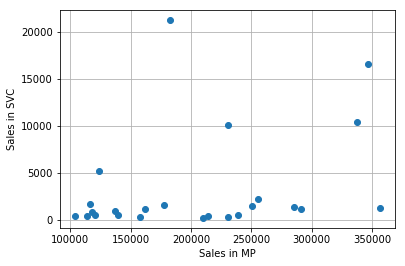

In [334]:
#looking at the graphs
group1remanMP14yearSales = np.ravel(MPgroup1reman[:,20:21])
group1remanSVC14yearSales = np.ravel(SVCgroup1reman[:,20:21])

plt.plot(group1remanMP14yearSales,group1remanSVC14yearSales,'o')
plt.xlabel('Sales in MP')
plt.ylabel('Sales in SVC')
plt.grid(True)

This is the function that I used to create a linear model based on a given data set. X would usually be the MP value after 14 years of sales and Y would be the SVC value after 14 years of sales.

In [335]:
def fit_linear(x,y):
    xm = np.mean(x)
    ym = np.mean(y)
    syy = np.mean((y-ym)**2)
    sxy = np.mean((x-xm)*(y-ym))
    sxx = np.mean((x-xm)**2)
    beta1 = sxy/sxx
    beta0 = ym - beta1*xm
    rsq = sxy**2/sxx/syy
    return beta0, beta1, rsq

After looking at the scatter plot of the data it is not very surpising that they linear model that was created had such a low correlation.

beta0 = -1243.848, beta1=0.022, rsq=0.101


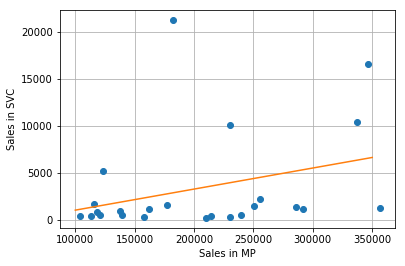

In [336]:
beta0,beta1,rsq = fit_linear(group1remanMP14yearSales,group1remanSVC14yearSales)
xp = np.linspace(100000,350000)
yp = beta0 + beta1*xp

plt.plot(group1MP14yearSales,group1SVC14yearSales,'o')
plt.xlabel('Sales in MP')
plt.ylabel('Sales in SVC')
plt.plot(xp,yp,'-')
plt.grid(True)

print("beta0 = {0:5.3f}, beta1={1:5.3f}, rsq={2:5.3f}".format(beta0,beta1,rsq))

I decied that I wanted to run the same linear model for each of the data sets above. The nonreman data set for the large MP values seemed to follow more of what I expected to show up.

beta0 = -111.069, beta1=0.013, rsq=0.644


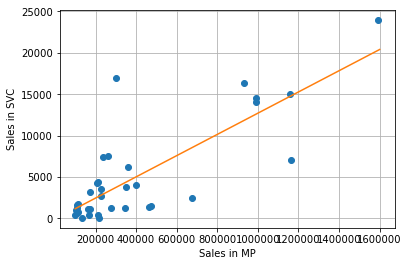

In [337]:
group1nonremanMP14yearSales = np.ravel(MPgroup1nonreman[:,20:21])
group1nonremanSVC14yearSales = np.ravel(SVCgroup1nonreman[:,20:21])

beta0,beta1,rsq = fit_linear(group1nonremanMP14yearSales,group1nonremanSVC14yearSales)
xp = np.linspace(100000,1600000)
yp = beta0 + beta1*xp

plt.plot(group1nonremanMP14yearSales,group1nonremanSVC14yearSales,'o')
plt.xlabel('Sales in MP')
plt.ylabel('Sales in SVC')
plt.plot(xp,yp,'-')
plt.grid(True)

print("beta0 = {0:5.3f}, beta1={1:5.3f}, rsq={2:5.3f}".format(beta0,beta1,rsq))

The rest of the graphs below all showed similar signs of the group 1 non reman parts. The r-squared value was very low and the line draw makes it seem like there is no correlation between the amount of parts sold in mass production to the number of parts sold in service parts. There are defintely are a few outliers in each data set to throw off the r-squared prediction but even if you omit them it still looks fairly constant in the number of parts needed in each range. 

beta0 = 837.666, beta1=-0.001, rsq=0.001


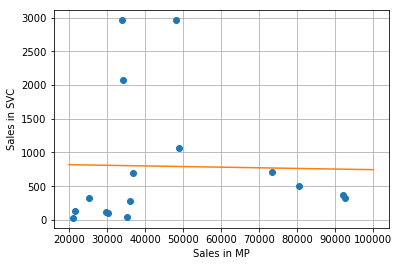

In [338]:
group2nonremanMP14yearSales = np.ravel(MPgroup2nonreman[:,20:21])
group2nonremanSVC14yearSales = np.ravel(SVCgroup2nonreman[:,20:21])

beta0,beta1,rsq = fit_linear(group2nonremanMP14yearSales,group2nonremanSVC14yearSales)
xp = np.linspace(20000,100000)
yp = beta0 + beta1*xp

plt.plot(group2nonremanMP14yearSales,group2nonremanSVC14yearSales,'o')
plt.xlabel('Sales in MP')
plt.ylabel('Sales in SVC')
plt.plot(xp,yp,'-')
plt.grid(True)

print("beta0 = {0:5.3f}, beta1={1:5.3f}, rsq={2:5.3f}".format(beta0,beta1,rsq))

beta0 = 1553.428, beta1=-0.009, rsq=0.014


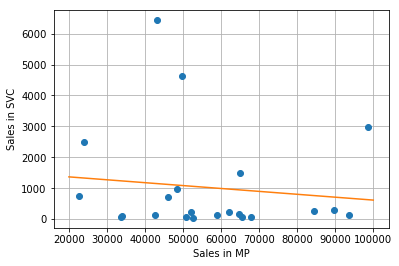

In [339]:
group2remanMP14yearSales = np.ravel(MPgroup2reman[:,20:21])
group2remanSVC14yearSales = np.ravel(SVCgroup2reman[:,20:21])

beta0,beta1,rsq = fit_linear(group2remanMP14yearSales,group2remanSVC14yearSales)
xp = np.linspace(20000,100000)
yp = beta0 + beta1*xp

plt.plot(group2remanMP14yearSales,group2remanSVC14yearSales,'o')
plt.xlabel('Sales in MP')
plt.ylabel('Sales in SVC')
plt.plot(xp,yp,'-')
plt.grid(True)

print("beta0 = {0:5.3f}, beta1={1:5.3f}, rsq={2:5.3f}".format(beta0,beta1,rsq))

beta0 = 48.730, beta1=0.052, rsq=0.028


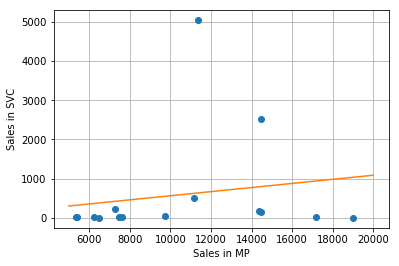

In [340]:
group3nonremanMP14yearSales = np.ravel(MPgroup3nonreman[:,20:21])
group3nonremanSVC14yearSales = np.ravel(SVCgroup3nonreman[:,20:21])

beta0,beta1,rsq = fit_linear(group3nonremanMP14yearSales,group3nonremanSVC14yearSales)
xp = np.linspace(5000,20000)
yp = beta0 + beta1*xp

plt.plot(group3nonremanMP14yearSales,group3nonremanSVC14yearSales,'o')
plt.xlabel('Sales in MP')
plt.ylabel('Sales in SVC')
plt.plot(xp,yp,'-')
plt.grid(True)

print("beta0 = {0:5.3f}, beta1={1:5.3f}, rsq={2:5.3f}".format(beta0,beta1,rsq))

beta0 = 226.608, beta1=-0.003, rsq=0.001


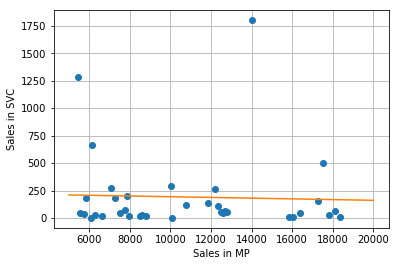

In [341]:
group3remanMP14yearSales = np.ravel(MPgroup3reman[:,20:21])
group3remanSVC14yearSales = np.ravel(SVCgroup3reman[:,20:21])

beta0,beta1,rsq = fit_linear(group3remanMP14yearSales,group3remanSVC14yearSales)
xp = np.linspace(5000,20000)
yp = beta0 + beta1*xp

plt.plot(group3remanMP14yearSales,group3remanSVC14yearSales,'o')
plt.xlabel('Sales in MP')
plt.ylabel('Sales in SVC')
plt.plot(xp,yp,'-')
plt.grid(True)

print("beta0 = {0:5.3f}, beta1={1:5.3f}, rsq={2:5.3f}".format(beta0,beta1,rsq))

beta0 = 74.025, beta1=0.096, rsq=0.018


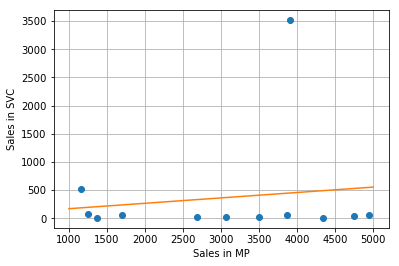

In [342]:
group4remanMP14yearSales = np.ravel(MPgroup4reman[:,20:21])
group4remanSVC14yearSales = np.ravel(SVCgroup4reman[:,20:21])

beta0,beta1,rsq = fit_linear(group4remanMP14yearSales,group4remanSVC14yearSales)
xp = np.linspace(1000,5000)
yp = beta0 + beta1*xp

plt.plot(group4remanMP14yearSales,group4remanSVC14yearSales,'o')
plt.xlabel('Sales in MP')
plt.ylabel('Sales in SVC')
plt.plot(xp,yp,'-')
plt.grid(True)

print("beta0 = {0:5.3f}, beta1={1:5.3f}, rsq={2:5.3f}".format(beta0,beta1,rsq))

I decied not to show most of the other calculations because it was all fairly the same or there was not enough data in each set to mean anything.

## Linear Regression modeling

I decided to take the model that I thought had the most promise in and ran a linear regression model on it. I fit the model to 2/3 of the data and tested it on the other 1/3. I ran the model using the 14-years of mass production and the total SVC part sale in total.

In [343]:
from sklearn import linear_model, preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support

regr = linear_model.LinearRegression()
logreg = linear_model.LogisticRegression(C=1e5)

Xs = MPgroup1nonreman[:,7:20]
Xs = preprocessing.scale(Xs)

ns_train = int(group1nonremanSVC14yearSales.size *2/3)
ns_test = int(group1nonremanSVC14yearSales.size) - ns_train

X_tr = Xs[:ns_train,:]
y_tr = group1nonremanSVC14yearSales[:ns_train]
X_ts = Xs[ns_test:,:]
y_ts = group1nonremanSVC14yearSales[ns_test:]

regr.fit(X_tr,y_tr)

C:\Users\chris\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Overall, even though the R-squared value is in the negative, by looking at the group it seems like one outlier completely threw off the r-squared value. But if we ignore it and look at the line of the actual vs predicted seems to fit fairly well on the data.

R^2 = -0.116710


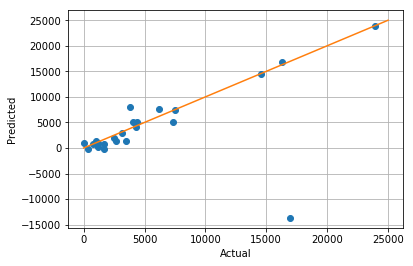

In [344]:
ytrain_pred = regr.predict(X_ts)

RSS_tr = np.mean((ytrain_pred-y_ts)**2)/(np.std(y_ts)**2)
Rsq_tr = 1-RSS_tr
print("R^2 = {0:f}".format(Rsq_tr))
plt.plot(y_ts,ytrain_pred,'o')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

xp = np.linspace(0,25000)
yp = 0 + 1*xp

plt.plot(xp,yp,'-')

## Evaluation and Interpretation

Overall, I feel like these results by themeselves will not be very useful, but I think I come out better understanding how I should have approached the problem. One of the major flaw that I should keep in mind, is that even though I seperated my data into 10 groups of reman/non-reman and number of mass production sales, I should have also seperated the data even more into their specific category of parts. It is obvious that different types of parts would need more replacement than other parts. Maybe if I took this into account then I would have a more definite answer of the data being linearly correlated or not. 

I think if I had a larger data set then I think I would have been more bold in seperating my data into more categories. But since I was only given data on around 200 parts, I felt like the more I tried to seperate the data, the more trouble I would have to interpreting the results, but it feels like the opposite has happened.